## Basic Example

This python notebook shows the basic usage of the unified planning library.

[![Open In GitHub](https://img.shields.io/badge/see-Github-579aca?logo=github)](https:///github.com/aiplan4eu/unified-planning/blob/master/docs/notebooks/01-basic-example.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aiplan4eu/unified-planning/blob/master/docs/notebooks/01-basic-example.ipynb)


In particular we will go through the following steps:

 - create a classical planning problem;
 - call a planner to solve the problem;
 - go beyond plan generation showing how to validate a plan and how to ground a planning problem;
 - call multiple planners in parallel.

### Setup


First, we install unified_planning library and its dependencies from PyPi. Here, we use the `--pre` flag to use the latest development build.

In [1]:
!apt install graphviz graphviz-dev
!pip install --pre unified-planning[pyperplan,tamer,plot]

The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.



zsh:1: no matches found: unified-planning[pyperplan,tamer,plot]


We are now ready to use the Unified-Planning library!

### Imports
The basic imports we need for this demo are abstracted in the `shortcuts` package.

In [2]:
import unified_planning
from unified_planning.shortcuts import *

### Problem representation

In this example, we will model a very simple robot navigation problem.

#### Types

The first thing to do is to introduce a "UserType" to model the concept of a location. It is possible to introduce as many types as needed; then, for each type we will define a set of objects of that type.  

In addition to `UserType`s we have three built-in types: `Bool`, `Real` and `Integer`.

In [3]:
Location = UserType('Location')

#### Fluents and constants

The basic variables of a planning problem are called "fluents" and are quantities that can change over time. Fluents can have differen types, in this first example we will stick to classical "predicates" that are fluents of boolean type. Moreover, fluents can have parameters: effectively describing multiple variables.

For example, a booean fluent `connected` with two parameters of type `Location` (that can be interpreted as `from` and `to`) can be used to model a graph of locations: there exists an edge between two locations `a` and `b` if `connected(a, b)` is true.

In this example, `connected` will be a constant (i.e. it will never change in any execution), but another fluent `robot_at` will be used to model where the robot is: the robot is in locatiopn `l` if and only if `robot_at(l)` is true (we will ensure that exactly one such `l` exists, so that the robot is always in one single location).

In [4]:
robot_at = unified_planning.model.Fluent('robot_at', BoolType(), l=Location)
connected = unified_planning.model.Fluent('connected', BoolType(), l_from=Location, l_to=Location)

#### Actions

Now we have the problem variables, but in order to describe the possible evolutions of a systems we need to describe how these variables can be changed and how they can evolve. We model this problem using classical, action-based planning, where a set of actions is used to characterize the possible transitions of the system from a state to another.

An action is a transition that can be applied if a specified set of preconditions is satisfied and that prescribes a set of effects that change the value of some fluents. All the fluents that are subjected to the action effects are unchanged.

We allow _lifted_ actions, that are action with parameters: the parameters can be used to specify preconditions or effects and the planner will select among the possible values of each parameters the ones to be used to characterize a specific action.

In our example, we introduce an action called `move` that has two parameters of type `Location` indicating the current position of the robot `l_from` and the intended destination of the movement `l_to`. The `move(a, b)` action is applicable only when the robot is in position `a` (i.e. `robot_at(a)`) and if `a` and `b` are connected locations (i.e. `connected(a, b)`). As a result of applying the action `move(a, b)`, the robot is no longer in `a` and is instead in location `b`.

In the unified_planning, we can create actions by instantiating the `unified_planning.InstantaneousAction` class; parameters are specified as keyword arguments to the constructor as shown below. Preconditions and effects are added by means of the `add_precondition` and `add_effect` methods.

In [5]:
move = unified_planning.model.InstantaneousAction('move', l_from=Location, l_to=Location)
l_from = move.parameter('l_from')
l_to = move.parameter('l_to')
move.add_precondition(connected(l_from, l_to))
move.add_precondition(robot_at(l_from))
move.add_effect(robot_at(l_from), False)
move.add_effect(robot_at(l_to), True)
print(move)

action move(Location l_from, Location l_to) {
    preconditions = [
      connected(l_from, l_to)
      robot_at(l_from)
    ]
    effects = [
      robot_at(l_from) := false
      robot_at(l_to) := true
    ]
  }


#### Creating the problem

The class that represents a planning problem is `unified_planning.Problem`, it contains the set of fluents, the actions, the objects, an intial value for all the fluents and a goal to be reached by the planner. We start by adding the entities we created so far. Note that entities are not bound to one problem, we can create the actions and fluents one and create multiple problems with them.

In [6]:
problem = unified_planning.model.Problem('robot')
problem.add_fluent(robot_at, default_initial_value=False)
problem.add_fluent(connected, default_initial_value=False)
problem.add_action(move)

The set of objects is a set of `unified_planning.Object` instances, each represnting an element of the domain. In this example, we create `NLOC` (set to 10) locations named `l0` to `l9`. We can create the set of objects and add it to the problem as follows.

In [7]:
NLOC = 10
locations = [unified_planning.model.Object('l%s' % i, Location) for i in range(NLOC)]
problem.add_objects(locations)

Then, we need to specify the initial state. We used the `default_initial_value` specification when adding the fluents, so it suffices to indicate the fluents that are initially true (this is called "closed-world assumption". Without this specification, we would need to initialize all the possible instantiation of all the fluents).

In this example, we connect location `li` with location `li+1`, creating a simple "linear" graph lof locations and we set the initial position of the robot in location `l0`.

In [8]:
problem.set_initial_value(robot_at(locations[0]), True)
for i in range(NLOC - 1):
    problem.set_initial_value(connected(locations[i], locations[i+1]), True)

Finally, we set the goal of the problem. In this example, we set ourselves to reach location `l9`.

In [9]:
problem.add_goal(robot_at(locations[-1]))
print(problem)

problem name = robot

types = [Location]

fluents = [
  bool robot_at[l=Location]
  bool connected[l_from=Location, l_to=Location]
]

actions = [
  action move(Location l_from, Location l_to) {
    preconditions = [
      connected(l_from, l_to)
      robot_at(l_from)
    ]
    effects = [
      robot_at(l_from) := false
      robot_at(l_to) := true
    ]
  }
]

objects = [
  Location: [l0, l1, l2, l3, l4, l5, l6, l7, l8, l9]
]

initial fluents default = [
  bool robot_at[l=Location] := false
  bool connected[l_from=Location, l_to=Location] := false
]

initial values = [
  robot_at(l0) := true
  connected(l0, l1) := true
  connected(l1, l2) := true
  connected(l2, l3) := true
  connected(l3, l4) := true
  connected(l4, l5) := true
  connected(l5, l6) := true
  connected(l6, l7) := true
  connected(l7, l8) := true
  connected(l8, l9) := true
]

goals = [
  robot_at(l9)
]




### Solving Planning Problems

The most direct way to solve a planning problem is to select an available planning engine by name and use it to solve the problem. In the following we use `pyperplan` to solve the problem and print the plan.

In [10]:
with OneshotPlanner(name='pyperplan') as planner:
    result = planner.solve(problem)
    if result.status == up.engines.PlanGenerationResultStatus.SOLVED_SATISFICING:
        print("Pyperplan returned: %s" % result.plan)
    else:
        print("No plan found.")

UPNoRequestedEngineAvailableException: 

The unified_planning can also automatically select, among the available planners installed on the system, one that is expressive enough for the problem at hand.

In [ ]:
with OneshotPlanner(problem_kind=problem.kind) as planner:
    result = planner.solve(problem)
    print("%s returned: %s" % (planner.name, result.plan))

  *** Credits ***
  * In operation mode `OneshotPlanner` at line 1 of `<ipython-input-29-5b1cb538ebee>`, you are using the following planning engine:
  * Engine name: pyperplan
  * Developers:  Albert-Ludwigs-Universität Freiburg (Yusra Alkhazraji, Matthias Frorath, Markus Grützner, Malte Helmert, Thomas Liebetraut, Robert Mattmüller, Manuela Ortlieb, Jendrik Seipp, Tobias Springenberg, Philip Stahl, Jan Wülfing)
  * Description: Pyperplan is a lightweight STRIPS planner written in Python.

Pyperplan returned: SequentialPlan:
    move(l0, l1)
    move(l1, l2)
    move(l2, l3)
    move(l3, l4)
    move(l4, l5)
    move(l5, l6)
    move(l6, l7)
    move(l7, l8)
    move(l8, l9)


In this example, Pyperplan was selected. The `problem.kind` property, returns an object that describes the characteristics of the problem.

In [ ]:
print(problem.kind.features)

{'FLAT_TYPING', 'ACTION_BASED'}


#### Beyond plan generation

`OneshotPlanner` is not the only operation mode we can invoke from the unified_planning, it is just one way to interact with a planning engine. Another useful functionality is `PlanValidation` that checks if a plan is valid for a problem.

In [ ]:
plan = result.plan
with PlanValidator(problem_kind=problem.kind, plan_kind=plan.kind) as validator:
    if validator.validate(problem, plan):
        print('The plan is valid')
    else:
        print('The plan is invalid')

  *** Credits ***
  * In operation mode `PlanValidator` at line 2 of `<ipython-input-31-af6de1fb604a>`, you are using the following planning engine:
  * Engine name: Tamer
  * Developers:  FBK Tamer Development Team
  * Description: Tamer offers the capability to generate a plan for classical, numerical and temporal problems.
  *              For those kind of problems tamer also offers the possibility of validating a submitted plan.

The plan is valid


It is also possible to use the `Compiler` operation mode with `compilation_kind=CompilationKind.GROUNDING` to create an equivalent formulation of a problem that does not use parameters for the actions.

For an in-depth tutorial about the `Compiler` operation mode check the [Notebook on Compilers](https://colab.research.google.com/github/aiplan4eu/unified-planning/blob/master/notebooks/Compilers_example.ipynb).

In [ ]:
with Compiler(problem_kind=problem.kind, compilation_kind=CompilationKind.GROUNDING) as grounder:
    grounding_result = grounder.compile(problem, CompilationKind.GROUNDING)
    ground_problem = grounding_result.problem
    print(ground_problem)

    # The grounding_result can be used to "lift" a ground plan back to the level of the original problem
    with OneshotPlanner(problem_kind=ground_problem.kind) as planner:
        ground_plan = planner.solve(ground_problem).plan
        print('Ground plan: %s' % ground_plan)
        # Replace the action instances of the grounded plan with their correspoding lifted version
        lifted_plan = ground_plan.replace_action_instances(grounding_result.map_back_action_instance)
        print('Lifted plan: %s' % lifted_plan)
        # Test the problem and plan validity
        with PlanValidator(problem_kind=problem.kind, plan_kind=ground_plan.kind) as validator:
            ground_validation = validator.validate(ground_problem, ground_plan)
            lift_validation = validator.validate(problem, lifted_plan)
            Valid = up.engines.ValidationResultStatus.VALID
            assert ground_validation.status == Valid
            assert lift_validation.status == Valid

  *** Credits ***
  * In operation mode `Compiler` at line 1 of `<ipython-input-32-ceba38deddc4>`, you are using the following planning engine:
  * Engine name: pyperplan
  * Developers:  Albert-Ludwigs-Universität Freiburg (Yusra Alkhazraji, Matthias Frorath, Markus Grützner, Malte Helmert, Thomas Liebetraut, Robert Mattmüller, Manuela Ortlieb, Jendrik Seipp, Tobias Springenberg, Philip Stahl, Jan Wülfing)
  * Description: Pyperplan is a lightweight STRIPS planner written in Python.

problem name = robot

types = [Location]

fluents = [
  bool robot_at[l=Location]
  bool connected[l_from=Location, l_to=Location]
]

actions = [
  action move_l3_l4 {
    preconditions = [
      robot_at(l3)
    ]
    effects = [
      robot_at(l4) := true
      robot_at(l3) := false
    ]
  }
  action move_l0_l1 {
    preconditions = [
      robot_at(l0)
    ]
    effects = [
      robot_at(l1) := true
      robot_at(l0) := false
    ]
  }
  action move_l6_l7 {
    preconditions = [
      robot_at(l6)
 

#### Parallel planning

We can invoke different instances of a planner in parallel or different planners and return the first plan that is generated effortlessly.

In [ ]:
with OneshotPlanner(names=['tamer', 'tamer', 'pyperplan'],
                    params=[{'heuristic': 'hadd'}, {'heuristic': 'hmax'}, {}]) as planner:
    plan = planner.solve(problem).plan
    print("%s returned: %s" % (planner.name, plan))

  *** Credits ***
  * In operation mode `OneshotPlanner` at line 1 of `<ipython-input-33-9fee18dbeff4>`, you are using a parallel planning engine with the following components:
  * Engine name: Tamer
  * Developers:  FBK Tamer Development Team
  * Description: Tamer offers the capability to generate a plan for classical, numerical and temporal problems.
  *              For those kind of problems tamer also offers the possibility of validating a submitted plan.
  * Engine name: Tamer
  * Developers:  FBK Tamer Development Team
  * Description: Tamer offers the capability to generate a plan for classical, numerical and temporal problems.
  *              For those kind of problems tamer also offers the possibility of validating a submitted plan.
  * Engine name: pyperplan
  * Developers:  Albert-Ludwigs-Universität Freiburg (Yusra Alkhazraji, Matthias Frorath, Markus Grützner, Malte Helmert, Thomas Liebetraut, Robert Mattmüller, Manuela Ortlieb, Jendrik Seipp, Tobias Springenberg, Phili

In [ ]:
from unified_planning.plot import plot_sequential_plan

Ignore the code below, it's used to make this notebook also runnable in the Countinuous Intergation.

In [ ]:
# Redefine the plot package methods imported above to print the plot to a temp file
# if the exception "could not locate runnable browser" is raised. This usually happens
# in the Continuous Integration.

from inspect import getmembers, isfunction
from unified_planning import plot
from functools import partial
import os, uuid, tempfile as tf

# Define the function that will be executed instead
def _function(original_function, *args, **kwargs):
    try:
        original_function(*args, **kwargs)
    except Exception as e:
        if "could not locate runnable browser" in str(e):
            original_function(*args, **kwargs,
                filename=f"{os.path.join(tf.gettempdir(), str(uuid.uuid1()))}.png"
            )
        else:
            raise e

# Iterate over all the functions of the plot package
for function_name, function in getmembers(plot, isfunction):
    # Override the original function with the new one
    globals()[function_name] = partial(_function, function)

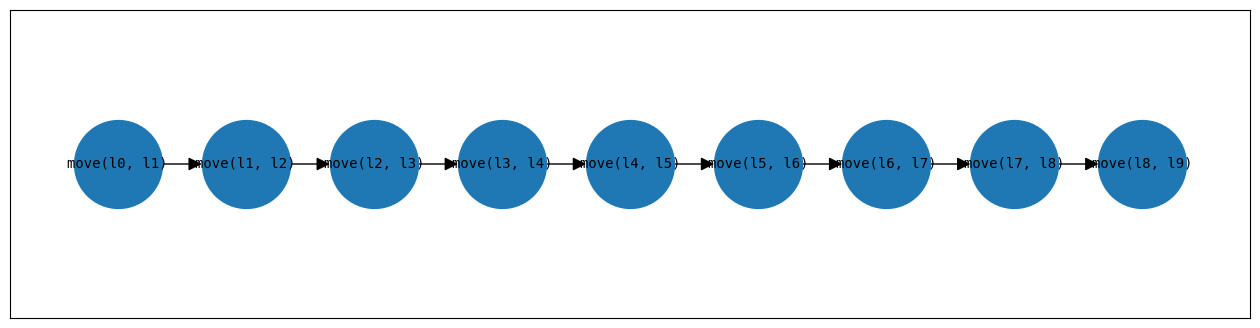

In [ ]:
if plan is not None:
    plot_sequential_plan(plan, figsize=(16, 4), node_size=4000, font_size=10)